Consider the finite problem defined as:

\begin{equation}
-\frac{\hbar^2}{2m} \frac{d^2  \psi}{dx^2}  + V(x) \psi =  E \psi
\end{equation}

where

*   $\hbar $ is the reduced Planck's constant
*   $m$ is the mass of particle
*  $\psi $ is the wavefunction (representing the eigenfunction/ eigenstate)
* $V(x) $ is the potential energy of the particle at any point $x$,
defined as
\begin{equation}
    V(x) =
    \begin{cases}
        0 & l_1 < x <  l_2, \\
        V_0 &  otherwise.
    \end{cases}
\end{equation}
* $E$ is the energy of the particle (representing the eigenvalue of the equation)

Taking $h = 1, m = 1 $ and $V_0 = 10$

In [1]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR

torch.manual_seed(1234)

np.random.seed(1234)

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device.type == 'cuda':
  print(torch.cuda.get_device_name(0))

#!pip install pyDOE
from pyDOE import lhs #latin hypercube sampling

cuda
NVIDIA RTX A6000


In [2]:
#Automatic differentiation in pytorch
def dfx(f, x):
    grads = []
    for i in range(f.shape[1]):  # iterate over columns
        grad_outputs = torch.zeros_like(f)
        grad_outputs[:, i] = 1.0
        df_i = grad(f, x, grad_outputs=grad_outputs, create_graph=True)[0]  # (n,1)
        grads.append(df_i.squeeze(-1))  # Remove extra dim to get (n,)
    return torch.stack(grads, dim=1)  # shape: (n, k)

In [3]:
#Defining the hyperparameters
t0 =-10; tf = 10; xbc = 0; eig_num = 5; gauss_num = 10 #Guess_num = 20 for the other pre_trainer
col_pts = 200 ;  layers = [1,512,512,256,256,128,gauss_num] #This is layer structure for the pretrained model
epochs =4000

In [4]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,t0,tf, bound):
  N1 = nn(t)
  f = ((1-torch.exp(-(t - t0)))*(1-torch.exp(t - tf))).view(-1,1)
  psi_hat = bound + f*N1 #Broadcasting is done here
  return psi_hat

In [5]:
def hamEqs_Loss(t, psi, psi_xx, v):

    # Hamiltonian applied to psi
    hamEqs = -0.5 * psi_xx + v * psi

    numerator = torch.trapz(psi * hamEqs, t, dim=0)
    denominator = torch.trapz(psi ** 2, t, dim=0)
    E = numerator / denominator

    # Residual (Schrödinger equation)
    L = psi_xx + (E - v) * psi

    return L, E


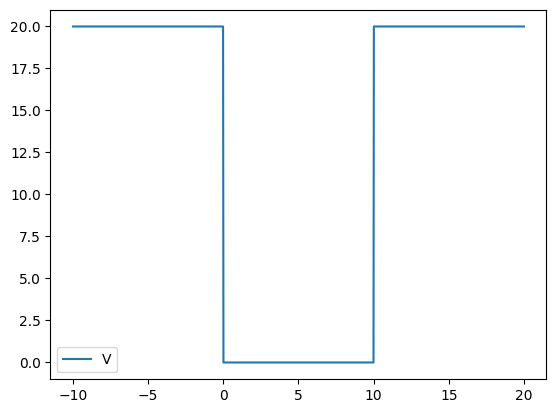

In [6]:
#defining the potential
def V(x):
  x = x.data.numpy()
  x0 = 10
  #vnp = (np.heaviside(-x-x0,0) + np.heaviside(x-x0,0))*20
  vnp = (np.heaviside(-x,0) + np.heaviside(x-x0,0))*20
  return torch.from_numpy(vnp)

x = torch.linspace(-10,20,1200).view(-1,1)
pot = V(x)
#scaled_pot = V_norm(x)

plt.plot(x,pot, label='V')
#plt.plot(x,scaled_pot, label='V_norm')
plt.legend()
plt.show()

In [7]:
#Defining the Frobenius norm
def frobenius_norm(G):
  I = torch.eye(G.shape[0], device = device, dtype = G.dtype)
  loss = torch.linalg.matrix_norm(G - I) #The frobenius norm
  return loss

#Defining the monotonicity_penalty
def monotonicity_penalty(E, margin = 0.0):
  diffs = E[:-1] - E[1:] + margin
  penalty = torch.relu(diffs).sum()
  return penalty

#Defining the cosine matrix using trapezoidal rule
def cosine_matrix(psi,x):
  psi_norm = torch.sqrt(torch.trapz(psi**2, x, dim=0))  # (k,)
  psi_normalized = psi / psi_norm  # (n, k)
  psi_prod = psi_normalized.unsqueeze(2) * psi_normalized.unsqueeze(1)  # (n, k, k)
  cos_matrix = torch.trapz(psi_prod, x, dim=0)
  return cos_matrix

In [8]:
class pre_trainerclass(torch.nn.Module):
  def __init__(self,layers):
    super(pre_trainerclass,self).__init__()
    self.activation = torch.sin

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

    #Initializing the weights
    #self.apply(weights_init)
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    #In1 = self.ein(torch.ones_like(a))
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      #z = self.batch_norms[i](z)
      a = self.activation(z)

    a = self.linears[-1](a)
    return a

In [9]:
# Freeze for feature extraction, or fine-tune
class transferred_model(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.activation = torch.sin
        self.features_list = nn.ModuleList(pretrained_model.linears)  # Include all layers
        self.new_head = nn.Linear(10, eig_num)

        #Freeze pretrained model weights
        for param in self.features_list.parameters():
            param.requires_grad = False

    def forward(self, t):
        for layer in self.features_list:
            t = self.activation(layer(t))
        return self.new_head(self.activation(t))
    
    def unfreeze_last_n_layers(self, n):
        """
        Unfreezes the last `n` layers of the pretrained feature extractor.
        """
        n = min(n, len(self.features_list))
        for i in range(1,n+1):
            for param in self.features_list[-i].parameters():
                param.requires_grad = True

##### Now we need to load the trained model weights for transfer learning then train for our problem

In [10]:
gaussian_model = pre_trainerclass(layers) #holder to initialize the pre-trained model weights

#The checkpoint
checkpoint = torch.load('checkpoints/gauss_modulated_pre_trainer.pth', map_location=torch.device('cuda'))

gaussian_model.load_state_dict(checkpoint['model_state_dict'])  #Load the weights into the holder
#gaussian_model.eval() #Set to evaluation
transfer_model = transferred_model(gaussian_model) #Transfer the model

#### Learning Rate Finder
We will find the best learning rate to start with

In [11]:
#We want to find the best lr for our defined model
model_lr = transfer_model.to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=1e-7)

In [12]:
def common_train_step(NN,t0,tf,xbc,t_rand):
    # Sort only the coordinates, without gradients
    with torch.no_grad():
        t_squeezed = t_rand.squeeze(-1)
        t_sort, idx = torch.sort(t_squeezed, dim=0)

    vx = V(t_sort.unsqueeze(1).cpu()).to(device)
    #Getting the parametric solution
    psi =parametricSolutions(t_rand,NN,t0,tf,xbc).to(device) #The forward pass

    # Compute second derivatives
    psi_x = dfx(psi, t_rand)
    psi_xx = dfx(psi_x, t_rand)

    psi_sort = psi[idx,:]; psi_xx_sort = psi_xx[idx,:]
    
    L,E = hamEqs_Loss(t_sort,psi_sort,psi_xx_sort,vx)
    Loss = torch.nn.MSELoss()
    #Getting the losses after each forward pass
    #We can also add the monotonicty loss
    pde_loss = Loss(L,torch.zeros_like(L))  #The scaled pde_loss
    G = cosine_matrix(psi_sort, t_sort)
    cosine_loss = 10.0*frobenius_norm(G)
    return pde_loss, cosine_loss, E

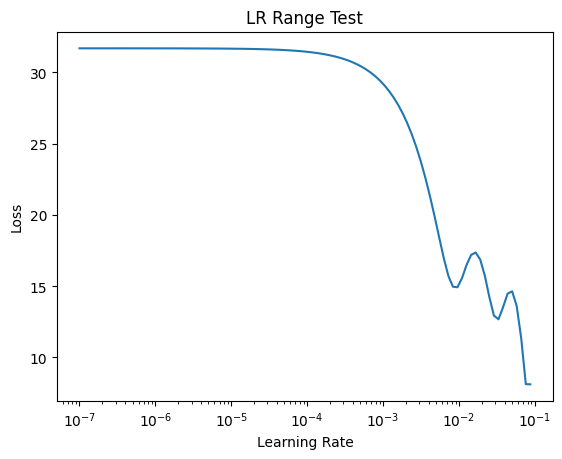

In [13]:
# Set up variables
x_lhs = torch.tensor(t0 + (tf - t0)*lhs(1,col_pts)).view(-1,1).to(device).float()
x_lhs.requires_grad =True
losses = []
lrs = []

start_lr = 1e-7
end_lr = 1e-1
num_iter = 100
lr_mult = (end_lr / start_lr) ** (1/num_iter)

lr = start_lr

for iteration in range(num_iter):
    optimizer_lr.param_groups[0]['lr'] = lr

    optimizer_lr.zero_grad()
    pde_loss,cosine_loss, _ = common_train_step(model_lr,t0,tf,xbc,x_lhs)
    loss = pde_loss + cosine_loss
    loss.backward()

    optimizer_lr.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= lr_mult  # increase learning rate exponentially

# Plot the result
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('LR Range Test')
plt.show()

It is important to note that the lr finder plot will change with different weights for the losses, so we should update accordingly

#### Training

In [14]:
#Now we initialize the model without freezing the pretrained weights
transfer_model.to(device)
print(transfer_model)
optimizer = optim.Adam(transfer_model.parameters(), lr=1e-4)
#scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-7)

transferred_model(
  (features_list): ModuleList(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
  (new_head): Linear(in_features=10, out_features=5, bias=True)
)


In [15]:
def nn_train(NN,t0,tf,xbc,epochs,t):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_keys = ['pde_loss_hist','cos_loss_hist','total_loss_hist']
  loss_dic = {key: [] for key in loss_keys} #To store the losses
  #t_rand = t[torch.randperm(t.shape[0])].to(device).float() #Reshuffling the collocation points
  t_rand = t.to(device).float()
  t_rand.requires_grad = True

  #Dictionary to store the final training
  dic = {}
  NN.unfreeze_last_n_layers(10)

  stime = time.time()
  for iter in range(epochs + 1):
    optimizer.zero_grad()
  
    criteria_loss,cosine_loss,En = common_train_step(NN,t0,tf,xbc,t_rand)
    total_loss = criteria_loss + cosine_loss
    
    En_history.append(En.cpu().detach().numpy())
    
    loss_dic['pde_loss_hist'].append(criteria_loss.cpu().detach().numpy().item())

    loss_dic['cos_loss_hist'].append(cosine_loss.cpu().detach().numpy().item())

    #if iter == 50:
    #  transfer_model.unfreeze_last_n_layers(2)
      


    if iter % 200 == 0:
      print('--------------------------------------------')
      print(f'Epoch: {iter}')
      print(f'En: {En_history[-1]}')
      print('--------------------------------------------')
      print('Total_loss: ',total_loss.item())
      print('pde_loss: ',criteria_loss.item())
      print('cos_loss: ',cosine_loss.item())
      



    #Backward propagation
    total_loss.backward()
    #Introducing Gradient clipping
    #max_norm =12.0
    #torch.nn.utils.clip_grad_norm_(NN.parameters(), max_norm)
    optimizer.step()
    #scheduler.step()

    #Storing the loss after each iteration

    loss_dic['total_loss_hist'].append(total_loss.cpu().detach().numpy())


  #Storing the final eigenfunction and eigenvalue
  dic[1] = copy.deepcopy(NN)


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, np.array(En_history), dic

In [16]:
x_lhs = torch.tensor(t0 + (tf - t0)*lhs(1,col_pts)).view(-1,1).float()
x_lhs.shape

torch.Size([200, 1])

In [17]:
Loss, eig_vals, qPINN = nn_train(transfer_model,t0,tf,xbc,epochs, x_lhs)

--------------------------------------------
Epoch: 0
En: [ 8.526054  14.919178   7.1961455  8.232991   2.6638103]
--------------------------------------------
Total_loss:  12.005505561828613
pde_loss:  5.399949550628662
cos_loss:  6.605556011199951
--------------------------------------------
Epoch: 200
En: [ 1.8944167  20.190813    1.7898757  19.828142    0.20901942]
--------------------------------------------
Total_loss:  1.828797698020935
pde_loss:  0.422720342874527
cos_loss:  1.4060773849487305
--------------------------------------------
Epoch: 400
En: [ 0.55676186 20.188051    1.025864   20.007092    0.29342693]
--------------------------------------------
Total_loss:  0.922947108745575
pde_loss:  0.20363469421863556
cos_loss:  0.7193124294281006
--------------------------------------------
Epoch: 600
En: [ 0.35966212 20.190361    0.70962405 20.056696    0.29412085]
--------------------------------------------
Total_loss:  0.4313358962535858
pde_loss:  0.1157260313630104
cos_l

In [18]:
tTest = torch.linspace(t0,tf,1200).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()

psi = parametricSolutions(tTest,qPINN[1].cpu(),t0,tf,xbc).data.numpy()

<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
C:\Users\idris_oduola\AppData\Local\Temp\ipykernel_24004\3215202776.py:24: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$\psi(x)$', color='black')


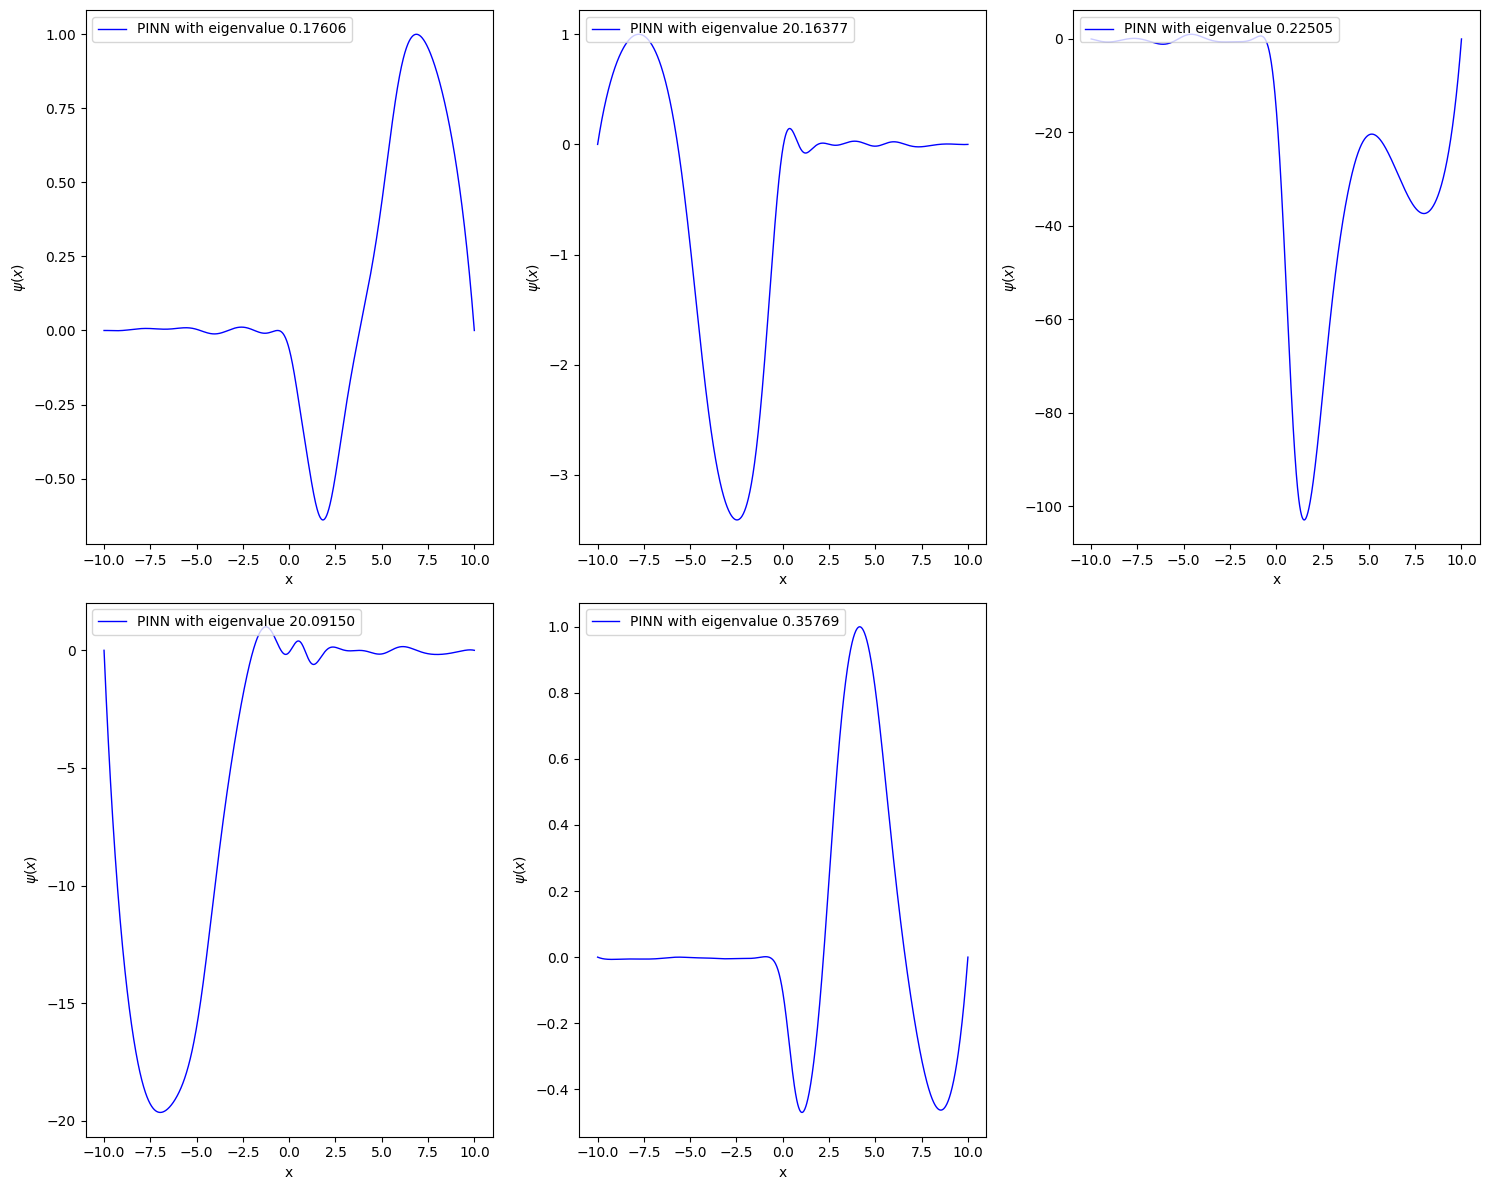

In [19]:
#Defining the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Calculating the total number of subplots needed
total_subplots = eig_vals[-1].shape[0]

# Creating a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterating over eigenvalues and corresponding solutions
for index, eig in enumerate(eig_vals[-1,:total_subplots]):
    row_index = index // num_cols  # row index
    col_index = index % num_cols   # column index

    # Plot on the corresponding subplot
    #psi_i = psi[index] + En_counter[index]
    ax = axes[row_index, col_index]
    max_val = abs(max(psi[:,index]))
    ax.plot(t_net, psi[:,index]/max_val, color='blue', linewidth=1, label=f'PINN with eigenvalue {eig_vals[-1,index]:.5f}')
    #ax.plot(t_net, V(torch.tensor(t_net)))
    #ax.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc = 'upper left')

# Hiding the unused subplot
if total_subplots < num_rows * num_cols:
    for i in range(total_subplots, num_rows * num_cols):
        fig.delaxes(axes.flat[i])
# Adjusting layout to prevent overlap
plt.tight_layout()

plt.show()

In [20]:
G = psi.T @ psi
G

array([[ 1.5495071e+02,  3.3365038e-01,  2.9011917e-01, -9.2007661e-01,
         9.5982742e-01],
       [ 3.3365038e-01,  2.1634438e+02,  4.1898745e-01,  1.0144613e+00,
         8.7099707e-01],
       [ 2.9011917e-01,  4.1898745e-01,  9.5218277e+01,  1.4281703e+00,
         1.6444016e-01],
       [-9.2007661e-01,  1.0144613e+00,  1.4281703e+00,  2.4581509e+02,
         1.2936199e+00],
       [ 9.5982742e-01,  8.7099707e-01,  1.6444016e-01,  1.2936199e+00,
         1.1395884e+02]], dtype=float32)

## Transfering with freezing pre-trainer parameters